In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
install.packages("GGally")
library("GGally")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
shoppers_data_full <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv")
shoppers_data_full

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0,0.2,0.2,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64,0.0,0.1,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0,0.2,0.2,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0,0,0,6,184.25,0.08333333,0.08666667,0,0,Nov,3,2,1,13,Returning_Visitor,TRUE,FALSE
4,75,0,0,15,346.00,0.00000000,0.02105263,0,0,Nov,2,2,3,11,Returning_Visitor,FALSE,FALSE
0,0,0,0,3,21.25,0.00000000,0.06666667,0,0,Nov,3,2,1,2,New_Visitor,TRUE,FALSE


In [3]:
shoppers_data <- shoppers_data_full %>% 
    select(BounceRates,ExitRates,PageValues,Revenue) %>% 
    mutate(Revenue = as_factor(Revenue))

In [4]:
set.seed(100)

shoppers_split <- initial_split(data = shoppers_data,
                                prop = 0.75,
                                strate = Revenue)

shoppers_training <- training(shoppers_split)
shoppers_testing <- testing(shoppers_split)

shoppers_recipe <- recipe(Revenue ~ ., data = shoppers_training) %>%
    step_upsample(Revenue, skip = TRUE)%>%
    prep()
bake(shoppers_recipe,shoppers_training)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


BounceRates,ExitRates,PageValues,Revenue
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0,FALSE
0.20,0.20,0,FALSE
0.05,0.14,0,FALSE
⋮,⋮,⋮,⋮
0.00000000,0.02133333,0,FALSE
0.08333333,0.08666667,0,FALSE
0.00000000,0.02105263,0,FALSE


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



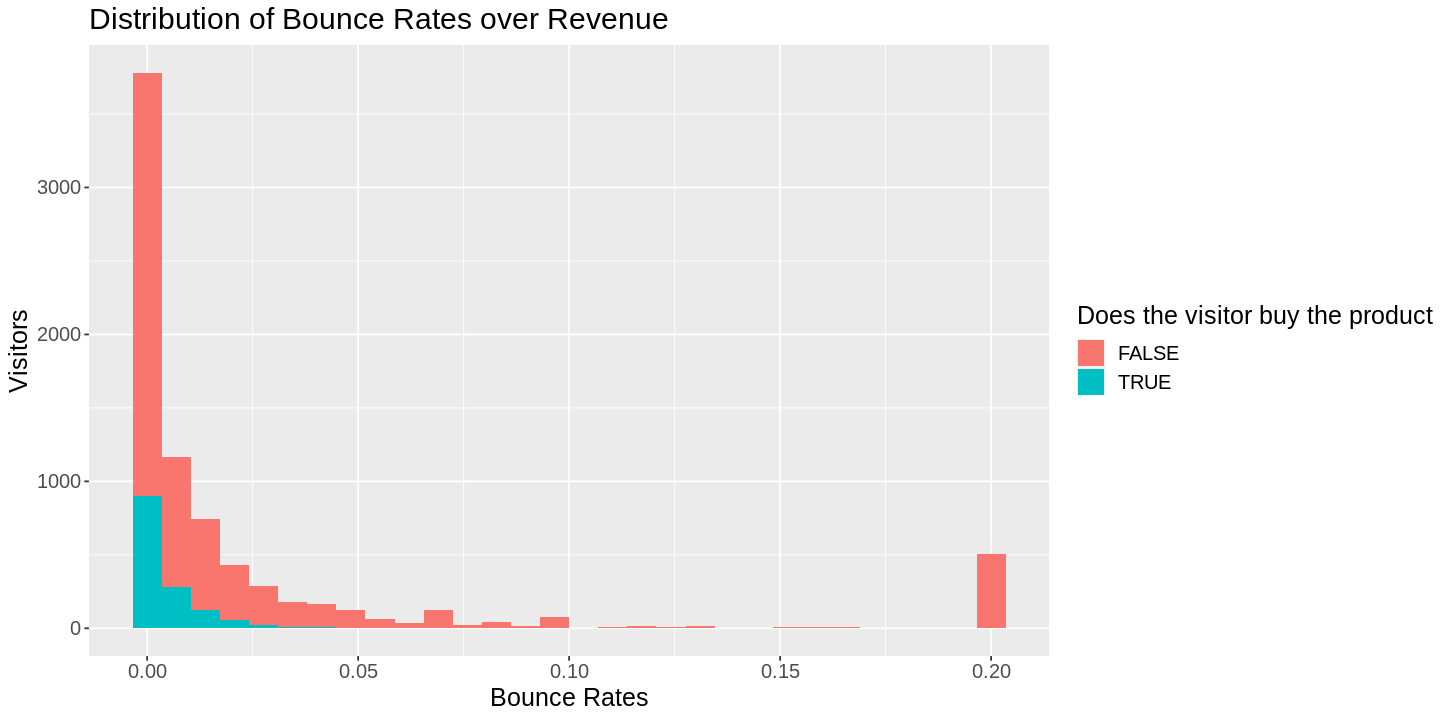

In [5]:
options(repr.plot.height = 6, repr.plot.width = 12)
bounce_hist <- ggplot(shoppers_training, aes(x = BounceRates, fill = Revenue)) +
    geom_histogram(position = "identity") +
    labs(x = "Bounce Rates", y = "Visitors", fill = "Does the visitor buy the product",title="Distribution of Bounce Rates over Revenue") +
    theme(text = element_text(size = 15))
bounce_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



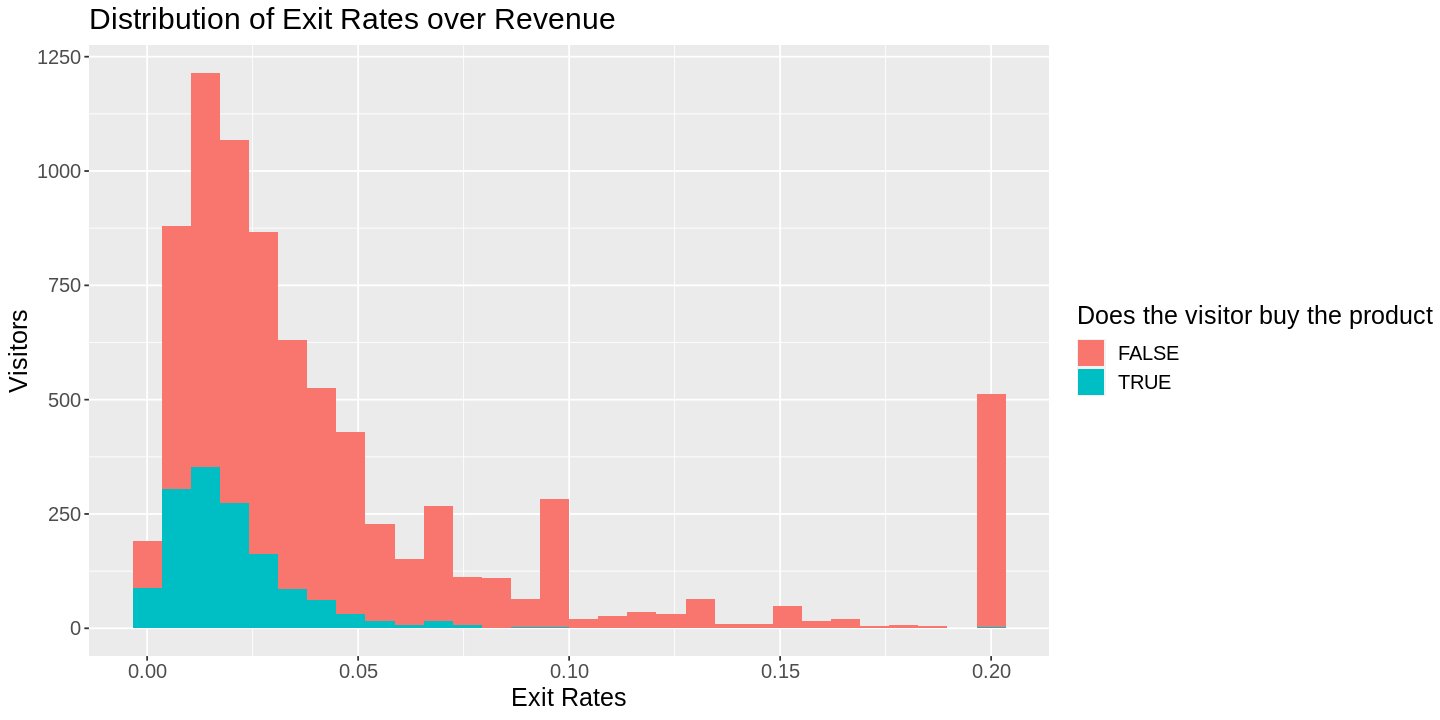

In [6]:
options(repr.plot.height = 6, repr.plot.width = 12)
exit_hist <- ggplot(shoppers_training, aes(x = ExitRates, fill = Revenue)) +
    geom_histogram(position = "identity") +
    labs(x = "Exit Rates", y = "Visitors", fill = "Does the visitor buy the product",title="Distribution of Exit Rates over Revenue") +
    theme(text = element_text(size = 15))
exit_hist

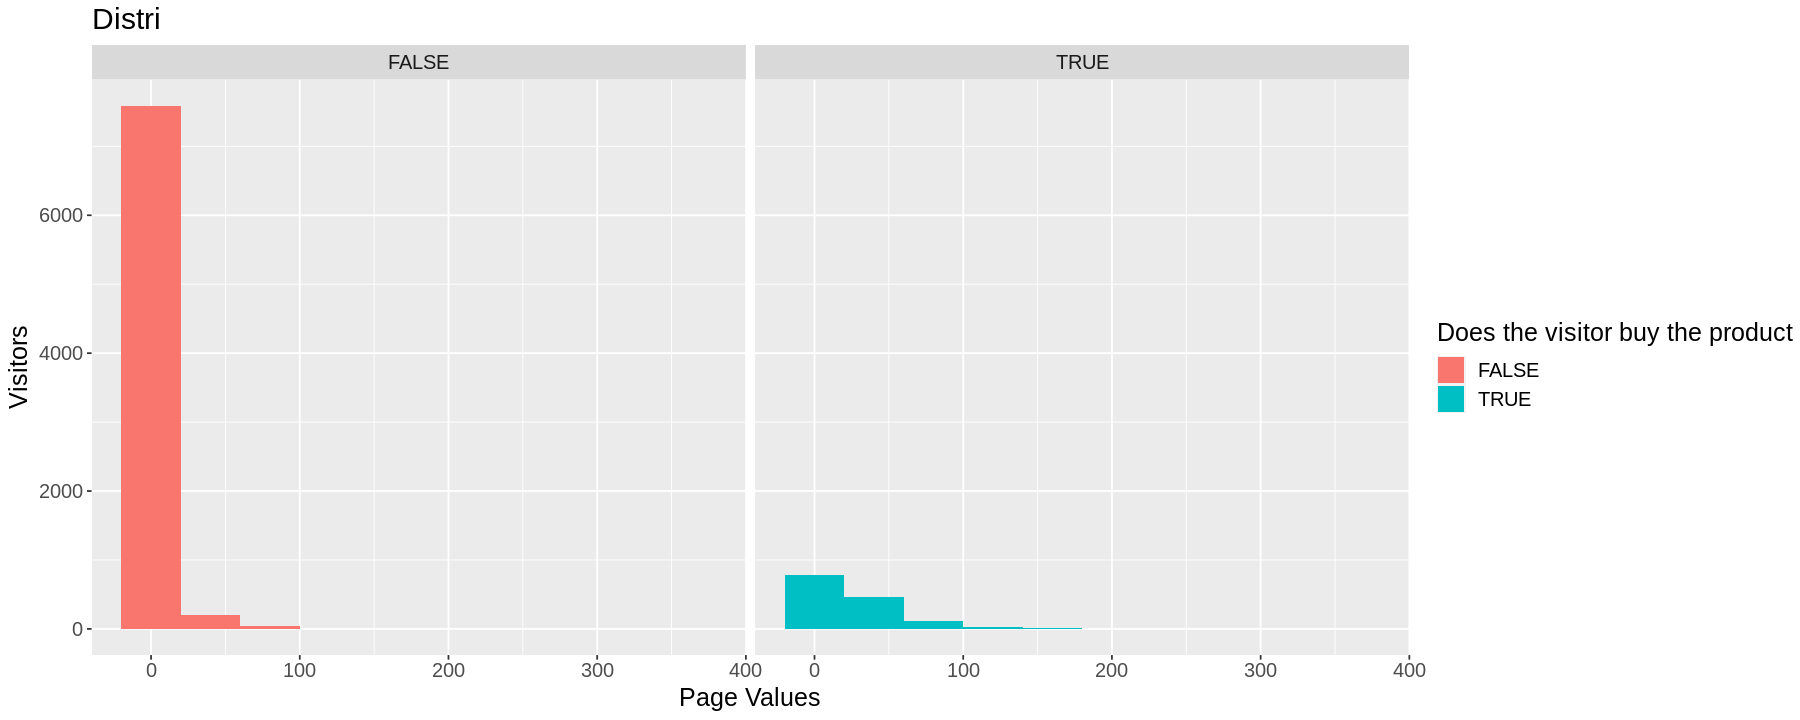

In [7]:
options(repr.plot.height = 6, repr.plot.width = 15)
page_values_hist <- ggplot(shoppers_training, aes(x = PageValues, fill = Revenue)) +
    geom_histogram(position = "identity",binwidth=40) +
    facet_grid(. ~ Revenue)+
    labs(x = "Page Values", y = "Visitors", fill = "Does the visitor buy the product",title="Distri") +
    theme(text = element_text(size = 15))
page_values_hist

In [8]:
shoppers_recipe <- shoppers_recipe %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

shoppers_vfold <- vfold_cv(shoppers_training, v = 5, strata = Revenue)

In [10]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

shoppers_vfold <- vfold_cv(shoppers_training, v = 5, strata = Revenue)

shoppers_workflow <- workflow() %>%
    add_recipe(shoppers_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = shoppers_vfold,
              grid = tibble(neighbors = seq(1, 20, 1))) %>%
    collect_metrics()

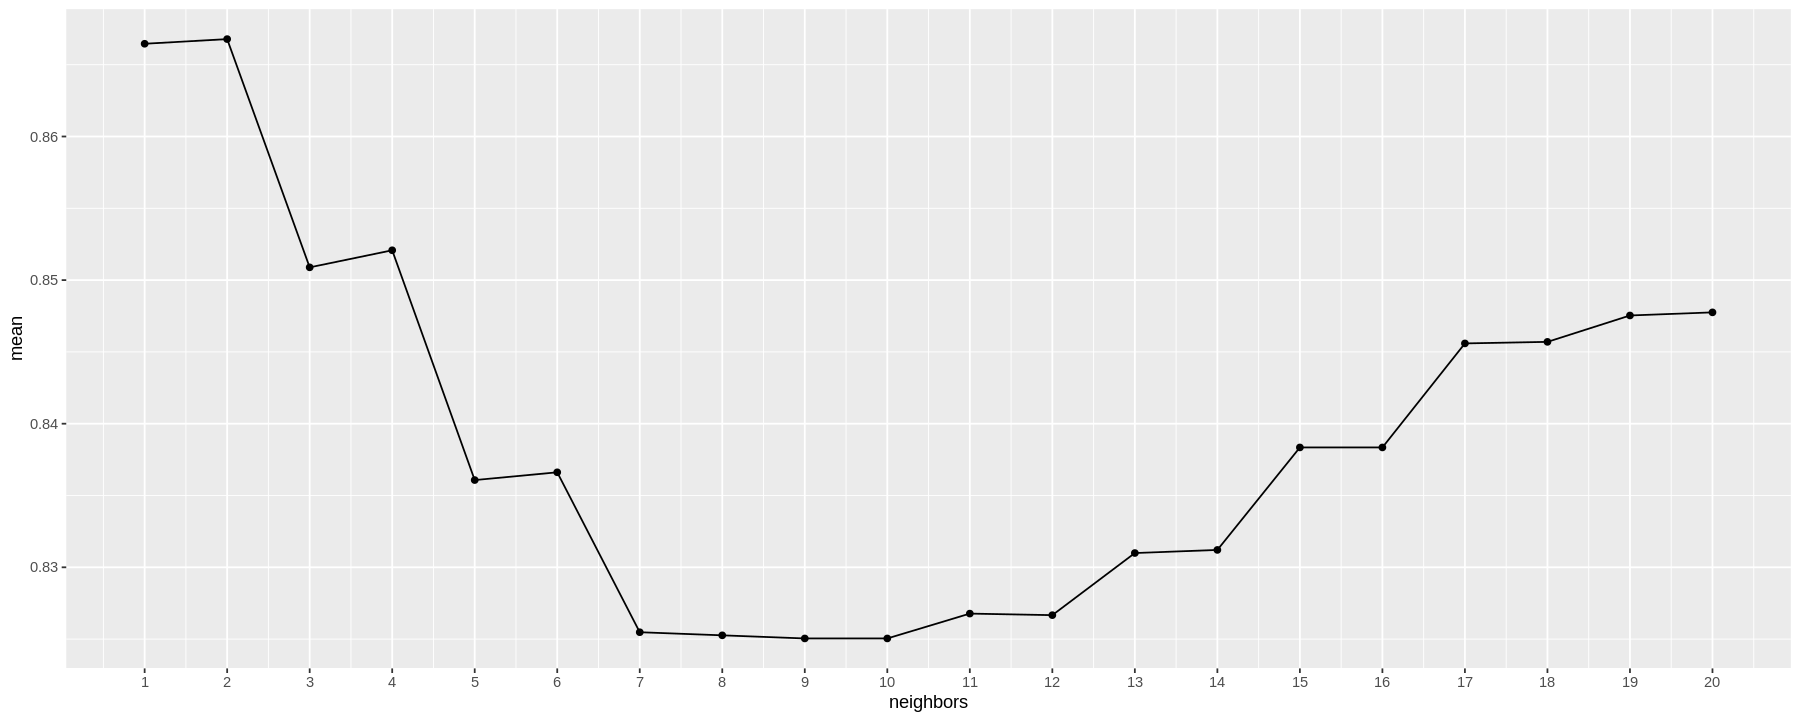

In [11]:
shoppers_accuracy <- shoppers_workflow %>%
    filter(.metric == 'accuracy') %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        scale_x_continuous(breaks = seq(1, 20, by = 1))
shoppers_accuracy

In [12]:
knn_spec_k2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 2) %>%
    set_engine('kknn') %>%
    set_mode('classification')

shoppers_workflow <- workflow() %>%
    add_recipe(shoppers_recipe) %>%
    add_model(knn_spec_k2) %>%
    fit(data = shoppers_training)

shoppers_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

● step_upsample()
● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07093602
Best kernel: rectangular
Best k: 2

In [13]:
prediction <- shoppers_workflow %>%
    predict(shoppers_testing) %>%
    bind_cols(shoppers_testing)

prediction_metrics <- prediction %>%
    metrics(truth = Revenue, estimate = .pred_class)   


prediction

prediction_metrics

.pred_class,BounceRates,ExitRates,PageValues,Revenue
<fct>,<dbl>,<dbl>,<dbl>,<fct>
FALSE,0.20000000,0.2000000,0,FALSE
FALSE,0.01578947,0.0245614,0,FALSE
FALSE,0.20000000,0.2000000,0,FALSE
⋮,⋮,⋮,⋮,⋮
FALSE,0.200000000,0.20000000,0.00000,FALSE
FALSE,0.007142857,0.02903061,12.24172,FALSE
FALSE,0.000000000,0.06666667,0.00000,FALSE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8637249
kap,binary,0.4756724


In [ ]:
shoppers_mat <- prediction %>%
      conf_mat(truth = Revenue, estimate = .pred_class)

shoppers_mat

In [22]:
# options(repr.plot.height = 12, repr.plot.width = 10)
# create the grid of area/smoothness vals, and arrange in a data frame
page_grid <- seq(min(shoppers_data$PageValues), max(shoppers_data$PageValues), length.out = 100)
bounce_grid <- seq(min(shoppers_data$BounceRates), max(shoppers_data$BounceRates), length.out = 100)
exit_grid <- seq(min(shoppers_data$ExitRates), max(shoppers_data$ExitRates), length.out = 100)
asgrid <- as_tibble(expand.grid(PageValues = page_grid, BounceRates = bounce_grid, ExitRates = exit_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(shoppers_workflow, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Revenue = .pred_class)

# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
page_bounce_plot <-
  ggplot() +
#   geom_point(data = shoppers_data, mapping = aes(x = PageValues, y = BounceRates, color = Revenue), alpha = 0.3) +
  geom_point(data = prediction_table, mapping = aes(x = PageValues, y = BounceRates, color = Revenue), alpha = 0.02, size = 5.) +
  labs(color = "Revenue")
#   scale_color_manual(labels = c("TRUE", "FALSE"))

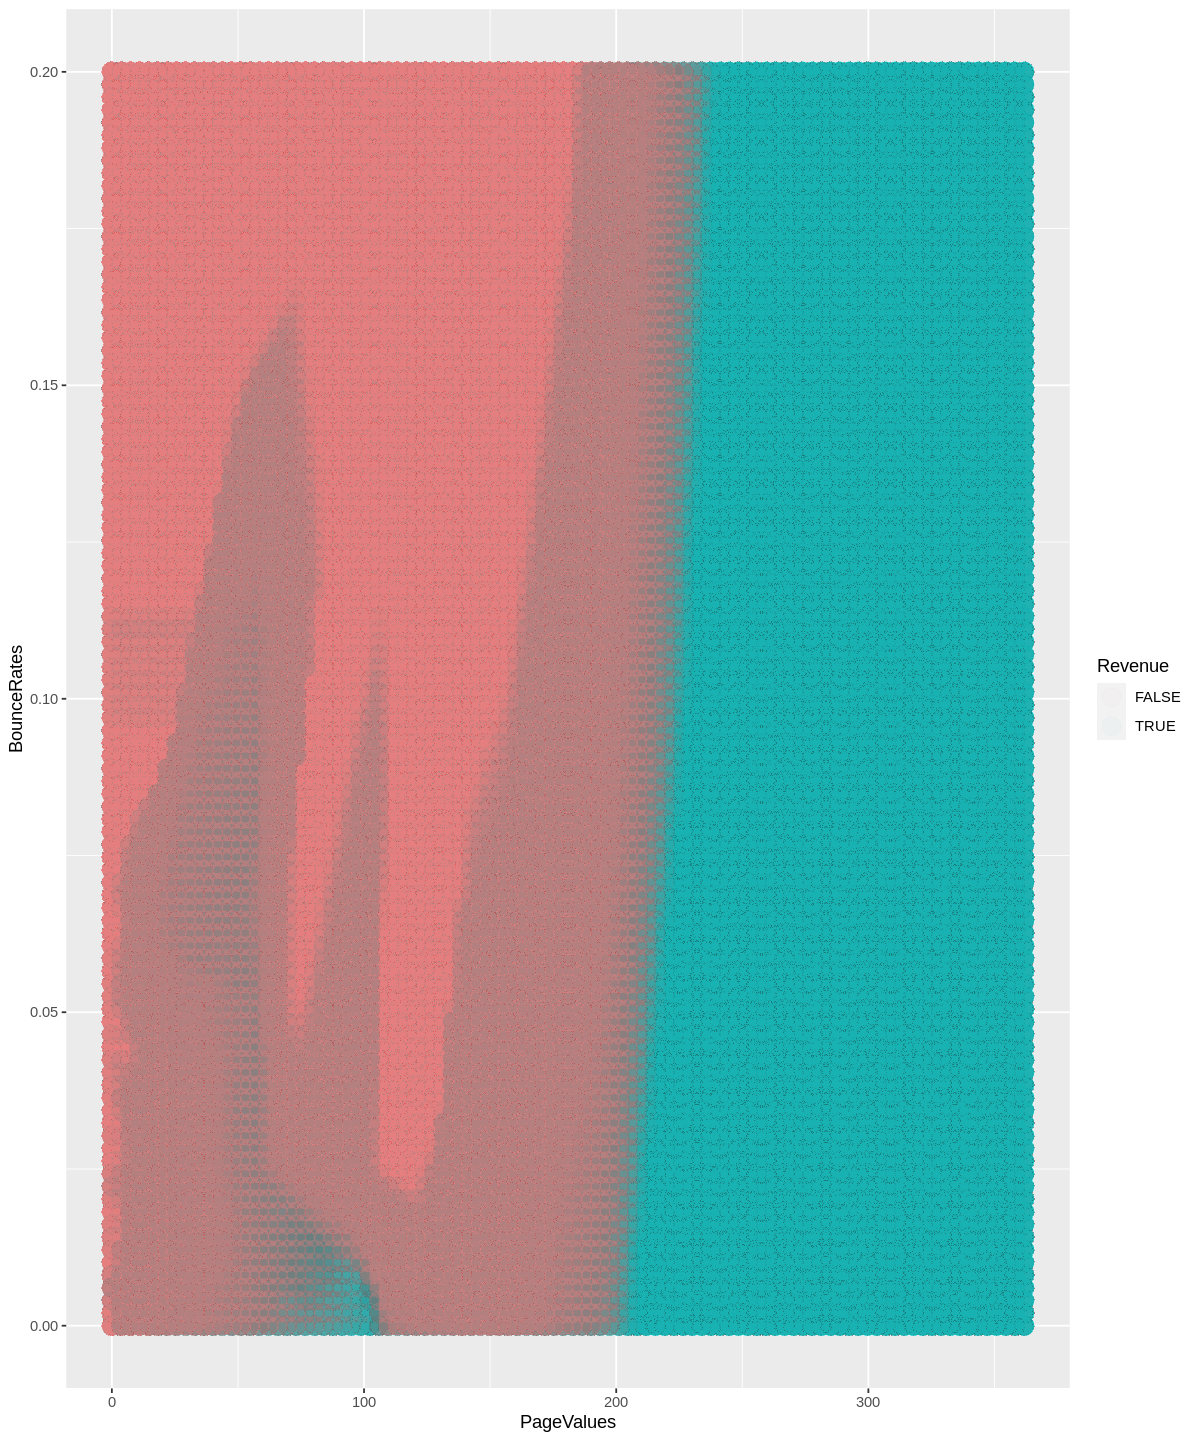

In [23]:
page_bounce_plot

In [27]:
bounce_exit_plot <-
  ggplot() +
  geom_point(data = shoppers_data, mapping = aes(x = BounceRates, y = ExitRates, color = Revenue), alpha = 0.3) +
  geom_point(data = prediction_table, mapping = aes(x = BounceRates, y = ExitRates, color = Revenue), alpha = 0.02, size = 5.) +
  labs(color = "Revenue") 
#   scale_color_manual(labels = c("Malignant", "Benign"), values = cbPalette)

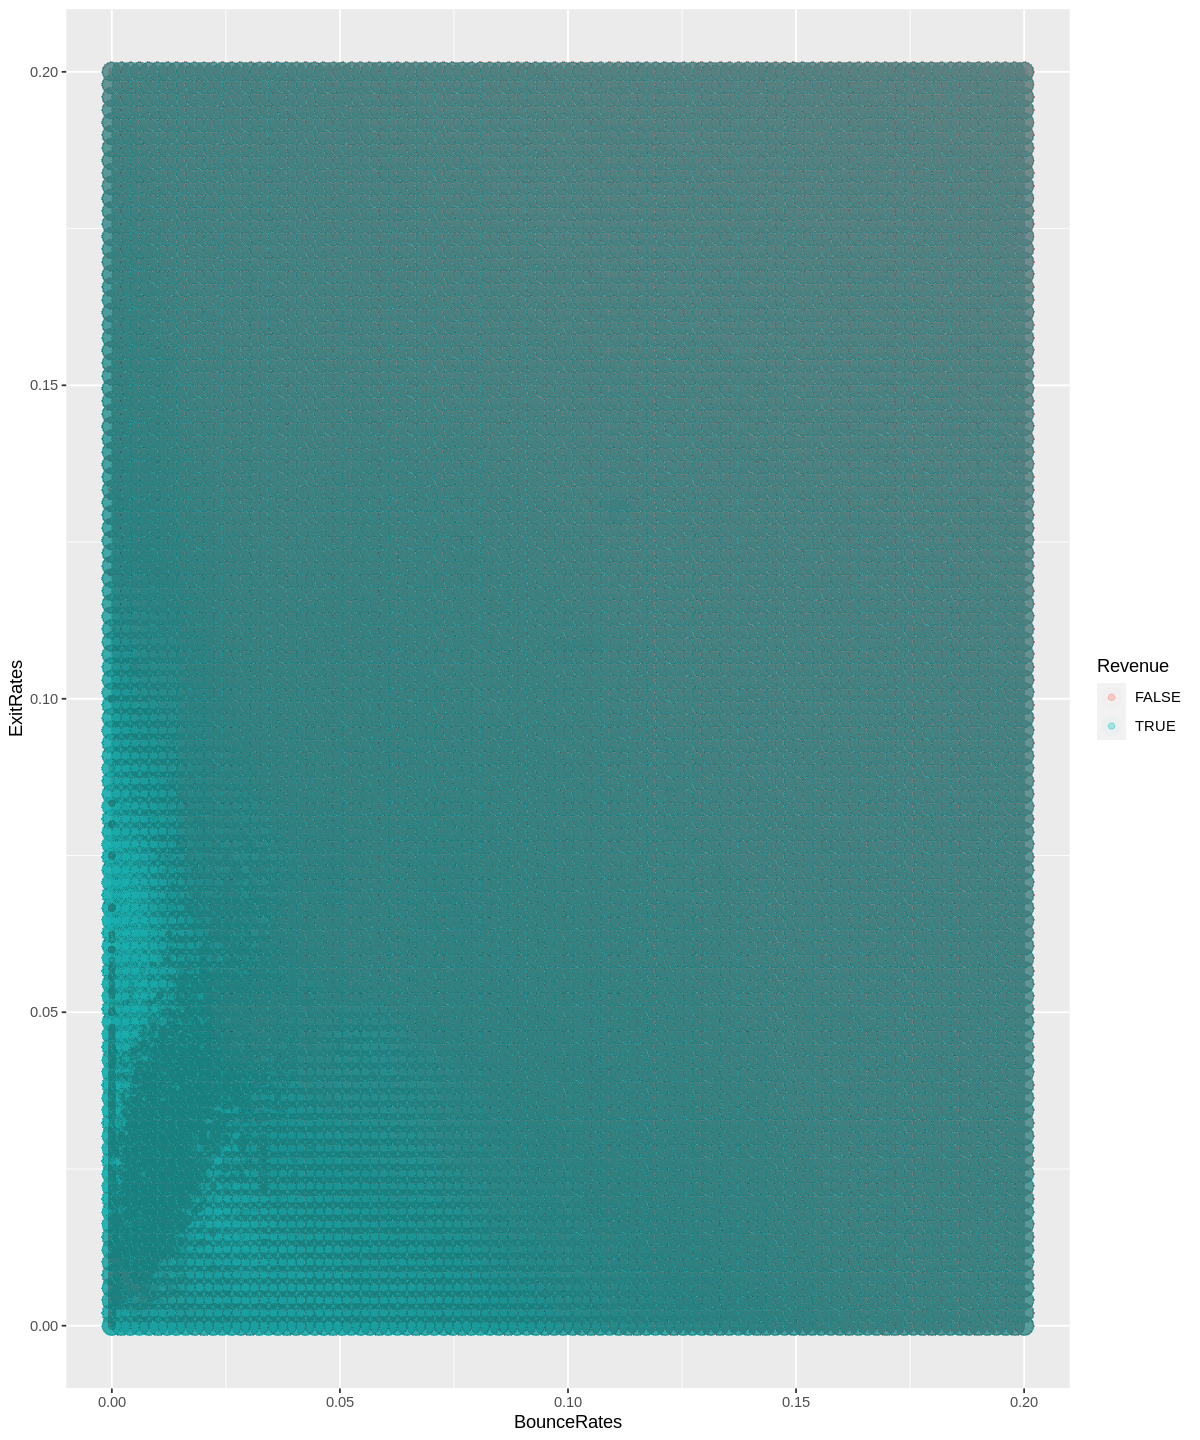

In [28]:
bounce_exit_plot

In [31]:
page_exit_plot <-
  ggplot() +
  geom_point(data = shoppers_data, mapping = aes(x = PageValues, y = ExitRates, color = Revenue), alpha = 0.3) +
  geom_point(data = prediction_table, mapping = aes(x = PageValues, y = ExitRates, color = Revenue), alpha = 0.02, size = 5.) +
  labs(color = "Revenue") 
#   scale_color_manual(labels = c("Malignant", "Benign"), values = cbPalette)

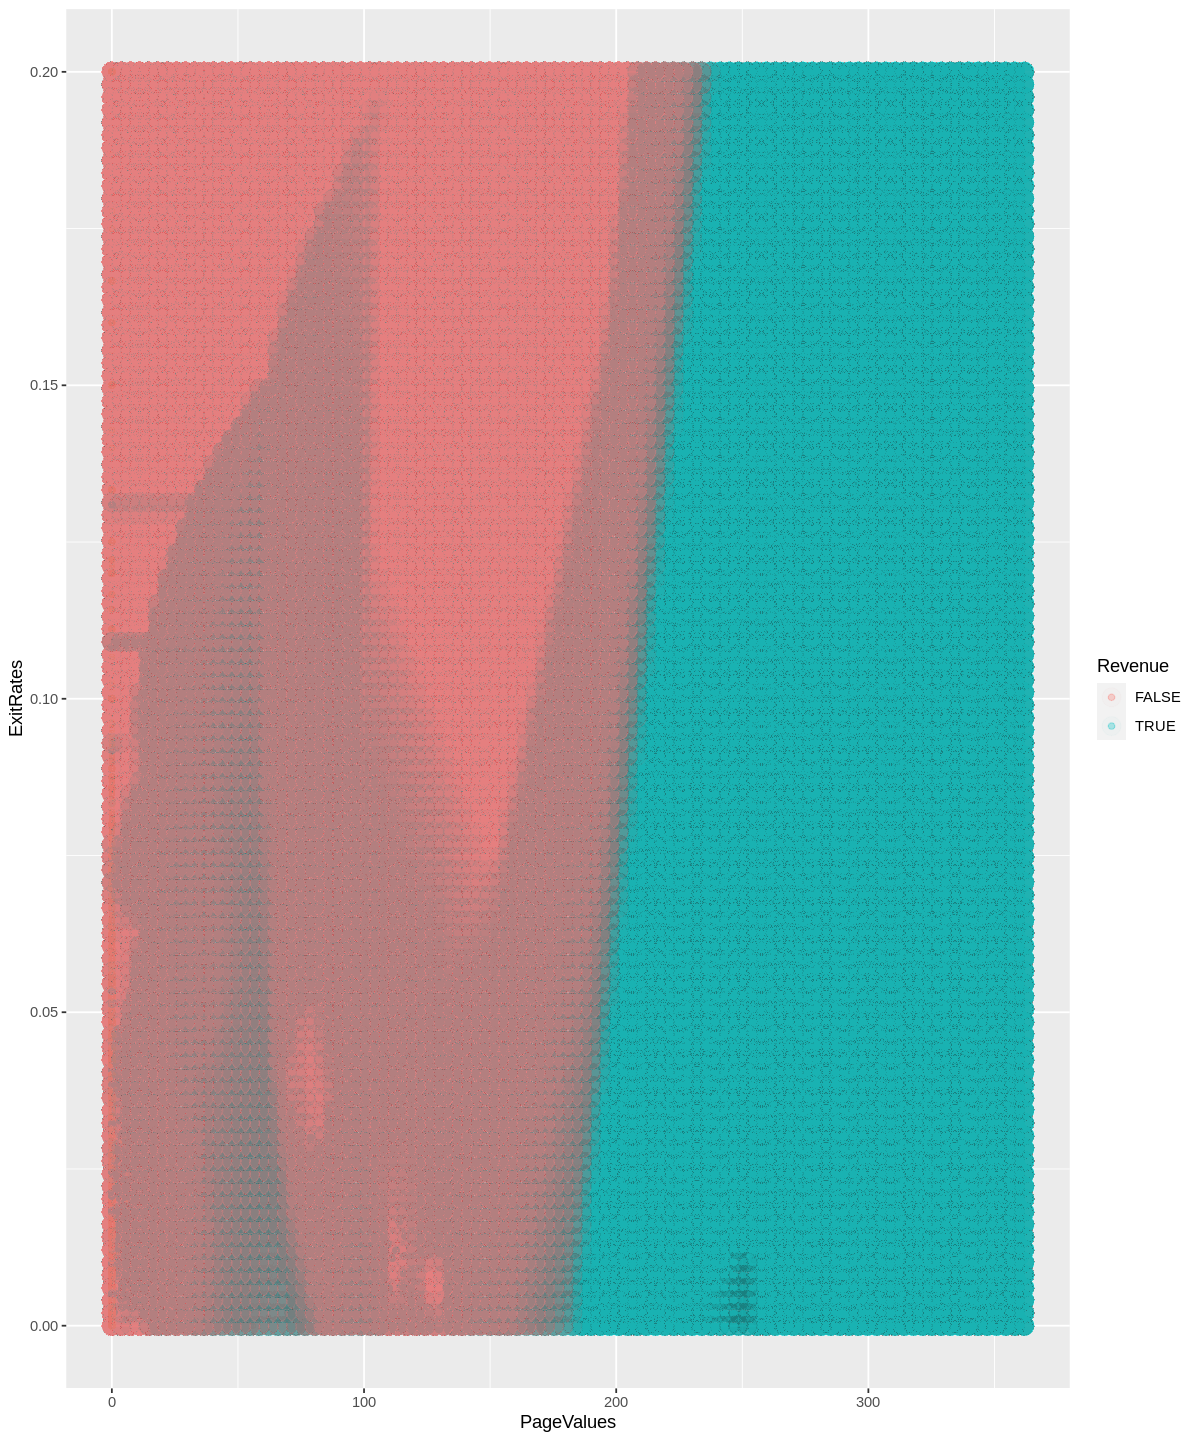

In [32]:
page_exit_plot